In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
from xenso import indices

In [2]:
DATA_DIR = "/glade/derecho/scratch/griverat/ics_CMIP6"

In [3]:
file_list = os.listdir(DATA_DIR)
file_list.sort()
models_members = {}
for _file in file_list:
    _name, _member, _ = _file.split(".")
    models_members[_name] = models_members.get(_name, [])
    models_members[_name].append(_member)
    models_members[_name].sort()
models_members

{'ACCESS-CM2': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'ACCESS-ESM1-5': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'CAMS-CSM1-0': ['r1i1p1f1', 'r1i1p1f2', 'r2i1p1f1'],
 'CAS-ESM2-0': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'CMCC-CM2-HR4': ['r1i1p1f1'],
 'CMCC-CM2-SR5': ['r1i1p1f1'],
 'CMCC-ESM2': ['r1i1p1f1'],
 'CNRM-CM6-1-HR': ['r1i1p1f2'],
 'CNRM-CM6-1': ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2'],
 'CNRM-ESM2-1': ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2'],
 'CanESM5-CanOE': ['r1i1p2f1', 'r2i1p2f1', 'r3i1p2f1'],
 'CanESM5': ['r1i1p1f1', 'r1i1p2f1', 'r2i1p1f1'],
 'EC-Earth3-AerChem': ['r1i1p1f1', 'r4i1p1f1'],
 'EC-Earth3-CC': ['r1i1p1f1'],
 'EC-Earth3-Veg-LR': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'EC-Earth3-Veg': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'EC-Earth3': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'FGOALS-f3-L': ['r1i1p1f1', 'r2i1p1f1', 'r3i1p1f1'],
 'GFDL-CM4': ['r1i1p1f1'],
 'GFDL-ESM4': ['r1i1p1f1'],
 'GISS-E2-1-G-CC': ['r1i1p1f1'],
 'GISS-E2-1-G': ['r1i1p1f1', 'r1i1p1f2', 'r2i1p1f1'],
 'GISS-

In [4]:
BWCUT_OFF = 120

alpha_dict = {}

for model_name, members in models_members.items():
    print(f"Doing model {model_name}")
    for member in members:
        print(f"Starting member: {member}")
        xfile_path = os.path.join(DATA_DIR, f"{model_name}.{member}.nc")
        # after regridding the datasets are really small, so we can leisurely load it
        # into memory
        xfile = xr.open_dataset(xfile_path).tos.load()

        xfile_anom = xfile.groupby("time.month").apply(lambda x: x - x.mean("time"))

        # We are using a lowpass filter to isolate the low freq signal to correct
        # each model output for bias.
        sos = signal.butter(5, 1 / BWCUT_OFF, btype="lowpass", output="sos")
        low_signal = signal.sosfiltfilt(
            sos, xfile_anom, axis=0, padtype="even", padlen=12 * 5
        )
        low_signal = xr.DataArray(low_signal, coords=xfile_anom.coords)

        # With this bias-corrected anomaly we can now compute the alpha parameter
        xfile_anom_no_low = xfile_anom - low_signal

        xfile_ecindex = indices.ECindex(
            xfile_anom_no_low,
            isanomaly=True,
            base_period=("1850", "2014"),
        )

        pc1 = xfile_ecindex.pcs.sel(mode=1)
        pc1 = pc1.sel(time=pc1.time.dt.month.isin([12, 1, 2]))
        pc1 = pc1.resample(time="QS-DEC").mean().dropna("time")

        pc2 = xfile_ecindex.pcs.sel(mode=2)
        pc2 = pc2.sel(time=pc2.time.dt.month.isin([12, 1, 2]))
        pc2 = pc2.resample(time="QS-DEC").mean().dropna("time")

        alpha, xfit, fit = xfile_ecindex.compute_alpha(pc1, pc2, return_fit=True)

        alpha_dict[model_name] = alpha_dict.get(model_name, {})
        alpha_dict[model_name][member] = alpha

Doing model ACCESS-CM2
Starting member: r1i1p1f1
Starting member: r2i1p1f1
Starting member: r3i1p1f1
Doing model ACCESS-ESM1-5
Starting member: r1i1p1f1
Starting member: r2i1p1f1
Starting member: r3i1p1f1
Doing model CAMS-CSM1-0
Starting member: r1i1p1f1
Starting member: r1i1p1f2
Starting member: r2i1p1f1
Doing model CAS-ESM2-0
Starting member: r1i1p1f1
Starting member: r2i1p1f1
Starting member: r3i1p1f1
Doing model CMCC-CM2-HR4
Starting member: r1i1p1f1
Doing model CMCC-CM2-SR5
Starting member: r1i1p1f1
Doing model CMCC-ESM2
Starting member: r1i1p1f1
Doing model CNRM-CM6-1-HR
Starting member: r1i1p1f2
Doing model CNRM-CM6-1
Starting member: r1i1p1f2
Starting member: r2i1p1f2
Starting member: r3i1p1f2
Doing model CNRM-ESM2-1
Starting member: r1i1p1f2
Starting member: r2i1p1f2
Starting member: r3i1p1f2
Doing model CanESM5-CanOE
Starting member: r1i1p2f1
Starting member: r2i1p2f1
Starting member: r3i1p2f1
Doing model CanESM5
Starting member: r1i1p1f1
Starting member: r1i1p2f1
Starting me

In [15]:
obs_ds = xr.open_dataset(
    "/glade/derecho/scratch/griverat/OBS/HadISST_sst.nc"
).sst.rename(latitude="lat", longitude="lon")
obs_ds["lon"] = np.where(obs_ds.lon < 0, obs_ds.lon + 360, obs_ds.lon)
obs_ds = obs_ds.sortby(["lat", "lon"])
obs_ds = obs_ds.where(obs_ds > -200)
sst_anom = obs_ds.groupby("time.month") - obs_ds.sel(
    time=slice("1991", "2020")
).groupby("time.month").mean(dim="time")
ecindex = indices.ECindex(
    sst_anom,
    isanomaly=True,
    base_period=("1991", "2020"),
)

pc1 = ecindex.pcs.sel(mode=1)
pc1 = pc1.sel(time=pc1.time.dt.month.isin([12, 1, 2]))
pc1 = pc1.resample(time="QS-DEC").mean().dropna("time")

pc2 = ecindex.pcs.sel(mode=2)
pc2 = pc2.sel(time=pc2.time.dt.month.isin([12, 1, 2]))
pc2 = pc2.resample(time="QS-DEC").mean().dropna("time")

alpha, xfit, fit = ecindex.compute_alpha(pc1, pc2, return_fit=True)

In [26]:
obs2_ds = xr.open_dataset("/glade/derecho/scratch/griverat/OBS/ersst.v5.nc").sst
obs2_ds["lon"] = np.where(obs2_ds.lon < 0, obs2_ds.lon + 360, obs2_ds.lon)
obs2_ds = obs2_ds.sortby(["lat", "lon"])
obs2_ds = obs2_ds.where(obs2_ds > -200)
sst2_anom = obs2_ds.groupby("time.month") - obs2_ds.sel(
    time=slice("1991", "2020")
).groupby("time.month").mean(dim="time")
ecindex2 = indices.ECindex(
    sst2_anom,
    isanomaly=True,
    base_period=("1991", "2020"),
)

pc1_2 = ecindex2.pcs.sel(mode=1)
pc1_2 = pc1_2.sel(time=pc1_2.time.dt.month.isin([12, 1, 2]))
pc1_2 = pc1_2.resample(time="QS-DEC").mean().dropna("time")

pc2_2 = ecindex2.pcs.sel(mode=2)
pc2_2 = pc2_2.sel(time=pc2_2.time.dt.month.isin([12, 1, 2]))
pc2_2 = pc2_2.resample(time="QS-DEC").mean().dropna("time")

alpha_2, xfit_2, fit_2 = ecindex2.compute_alpha(pc1_2, pc2_2, return_fit=True)

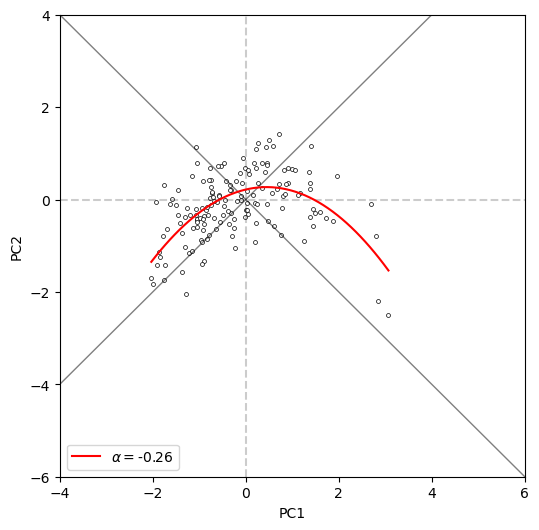

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.axhline(0, color="k", linestyle="--", alpha=0.2)
ax.axvline(0, color="k", linestyle="--", alpha=0.2)

# draw a line 45 degrees
x = np.linspace(-6, 6, 100)
y = x
ax.plot(x, y, color="k", alpha=0.5, lw=1)
ax.plot(-x, y, color="k", alpha=0.5, lw=1)

ax.scatter(
    pc1,
    pc2,
    s=8,
    marker="o",
    c="w",
    edgecolors="k",
    linewidths=0.5,
)

ax.plot(xfit, fit, c="r", label=f"$\\alpha=${alpha:.2f}")

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")

# ax.set_title(f"{MODEL_NAME} ({MEMBER}) -- Average (DJF) PC1 vs PC2")

ax.set_xlim(-4, 6)
ax.set_ylim(-6, 4)
ax.legend()

In [28]:
alpha_plot_data = {}
for k, v in alpha_dict.items():
    for num, a in enumerate(v.values()):
        alpha_plot_data[k] = alpha_plot_data.get(k, {})
        alpha_plot_data[k][num] = a

df = pd.DataFrame(alpha_plot_data).T.sort_values(0)
df.loc["HadISST"] = [alpha, np.nan, np.nan]
df.loc["ERSSTv5"] = [alpha_2, np.nan, np.nan]
df.head()

,0,1,2
GISS-E2-1-G-CC,-0.819608,NaN,NaN
GISS-E2-1-G,-0.721067,-0.562506,-0.655296
MIROC-ES2L,-0.707900,-0.600486,-0.497257
CMCC-ESM2,-0.561321,NaN,NaN
FGOALS-f3-L,-0.478233,-0.392695,-0.500166


In [37]:
df.loc[["HadISST", "ERSSTv5"]][0].mean()

-0.24063731886292594

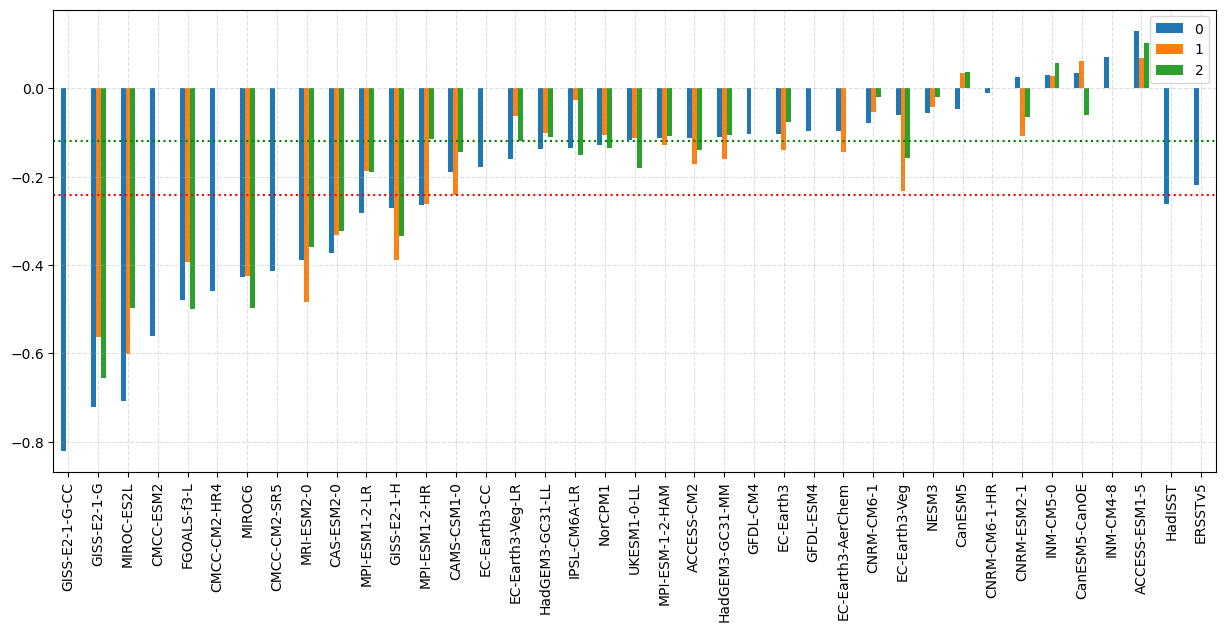

In [36]:
fig, ax = plt.subplots(figsize=(15, 6))
df.plot.bar(ax=ax)
ax.grid(ls="--", alpha=0.4)
ax.axhline(df.loc[["HadISST", "ERSSTv5"]][0].mean(), c="r", ls="dotted")
ax.axhline(df.loc[["HadISST", "ERSSTv5"]][0].mean() / 2, c="g", ls="dotted")

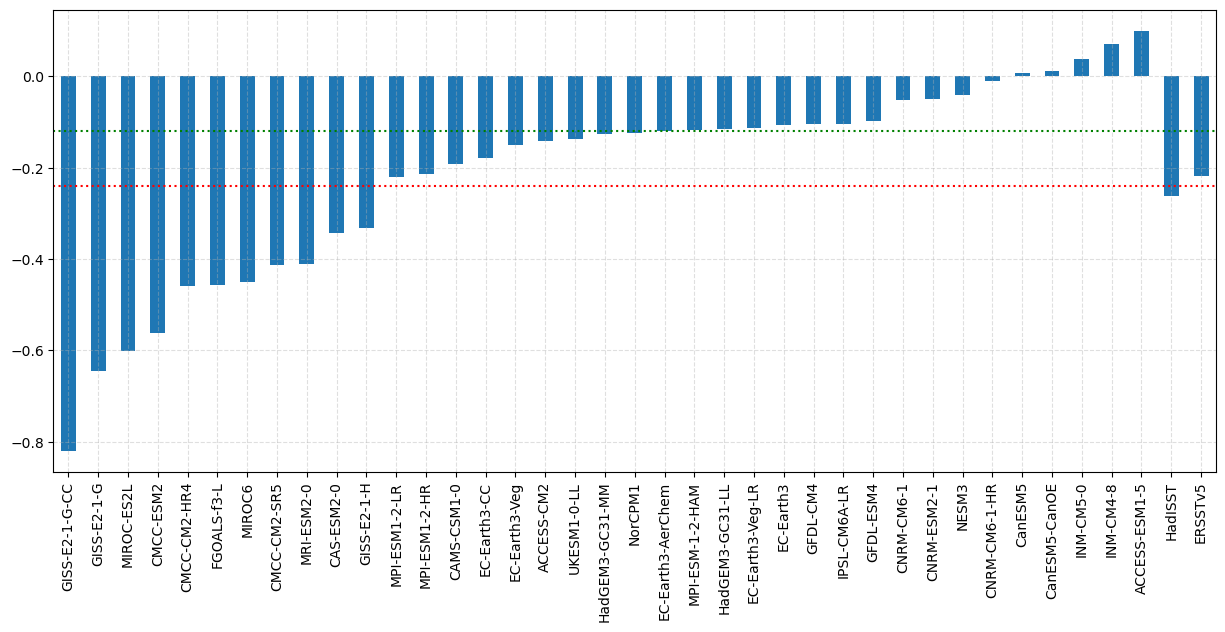

In [38]:
df = pd.DataFrame(alpha_dict).T.mean(axis=1).sort_values()
df.loc["HadISST"] = alpha
df.loc["ERSSTv5"] = alpha_2

fig, ax = plt.subplots(figsize=(15, 6))
df.plot.bar(ax=ax)
ax.grid(ls="--", alpha=0.4)
ax.axhline(df.loc[["HadISST", "ERSSTv5"]].mean(), c="r", ls="dotted")
ax.axhline(df.loc[["HadISST", "ERSSTv5"]].mean() / 2, c="g", ls="dotted")

In [41]:
df.iloc[:-2]

GISS-E2-1-G-CC      -0.819608
GISS-E2-1-G         -0.646290
MIROC-ES2L          -0.601881
CMCC-ESM2           -0.561321
CMCC-CM2-HR4        -0.458945
FGOALS-f3-L         -0.457031
MIROC6              -0.450429
CMCC-CM2-SR5        -0.414064
MRI-ESM2-0          -0.409966
CAS-ESM2-0          -0.343526
GISS-E2-1-H         -0.331626
MPI-ESM1-2-LR       -0.219773
MPI-ESM1-2-HR       -0.213537
CAMS-CSM1-0         -0.191939
EC-Earth3-CC        -0.178216
EC-Earth3-Veg       -0.150599
ACCESS-CM2          -0.140934
UKESM1-0-LL         -0.136657
HadGEM3-GC31-MM     -0.125823
NorCPM1             -0.124022
EC-Earth3-AerChem   -0.120206
MPI-ESM-1-2-HAM     -0.116899
HadGEM3-GC31-LL     -0.115854
EC-Earth3-Veg-LR    -0.114090
EC-Earth3           -0.106534
GFDL-CM4            -0.104301
IPSL-CM6A-LR        -0.104238
GFDL-ESM4           -0.097382
CNRM-CM6-1          -0.050680
CNRM-ESM2-1         -0.049837
NESM3               -0.039657
CNRM-CM6-1-HR       -0.011036
CanESM5              0.008108
CanESM5-Ca

In [42]:
selected_models = df.iloc[:-2][
    np.abs(df.iloc[:-2]) > np.abs(df.loc[["HadISST", "ERSSTv5"]].mean()) / 2
].index.to_list()
with open("selected_models.txt", "w") as f:
    f.writelines("\n".join(selected_models))
selected_models

['GISS-E2-1-G-CC',
 'GISS-E2-1-G',
 'MIROC-ES2L',
 'CMCC-ESM2',
 'CMCC-CM2-HR4',
 'FGOALS-f3-L',
 'MIROC6',
 'CMCC-CM2-SR5',
 'MRI-ESM2-0',
 'CAS-ESM2-0',
 'GISS-E2-1-H',
 'MPI-ESM1-2-LR',
 'MPI-ESM1-2-HR',
 'CAMS-CSM1-0',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'ACCESS-CM2',
 'UKESM1-0-LL',
 'HadGEM3-GC31-MM',
 'NorCPM1']